## Set plots show in notebook

In [28]:
%matplotlib inline

## Set dataset path

The dogcats directory contains two sub directories, train and valid. The valid is used for finetune, that is modified VGG16 model to identify dogs or cats based on its already trained parameters. 

In [16]:
path = "../data/dogscats/"
# path = "../data/dogscats/sample/"

In [4]:
from __future__ import division, print_function
import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt
import utils; reload(utils)  
from utils import plots

## Use original Vgg16 without finetune 

Vgg16 models recognise the main imagenet 1000 categories for each image.

In [6]:
from vgg16 import Vgg16
vgg = Vgg16()

In [9]:
# batches is an iterator that returns two lists, imgs and their labels.
# batch_size is the number of images to train at once 
# in order to speed up and avoid running out of memory.
batches = vgg.get_batches(path + 'train', batch_size=4)

Found 16 images belonging to 2 classes.


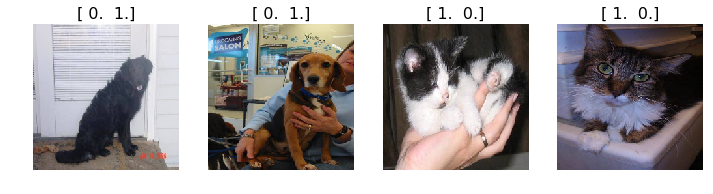

In [11]:
imgs, labels = next(batches)
plots(imgs, titles=labels)

In [12]:
# try to predict the dogs or cats images by original Vgg16
vgg.predict(imgs, True)

(array([ 0.3599,  0.3414,  0.1613,  0.5164], dtype=float32),
 array([233, 237, 333, 281]),
 [u'Bouvier_des_Flandres', u'miniature_pinscher', u'hamster', u'tabby'])

In [13]:
# vgg's 1000 categories 
vgg.classes[:4]

[u'tench', u'goldfish', u'great_white_shark', u'tiger_shark']

## Use Vgg16 model to finetune Dogs vs Cats

In [16]:
# to finetune vgg16, call vgg.finetune and vgg.fit by this order.
# val_batches is a batch for finetune validation
# epoch is one full pass through the training data
batch_size = 64
batches = vgg.get_batches(path + 'train', batch_size=batch_size)
val_batches = vgg.get_batches(path + 'valid', batch_size=batch_size)
vgg.finetune(batches)
vgg.fit(batches, val_batches, nb_epoch=1)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Epoch 1/1
23000/23000 [==============================] - 601s - loss: 0.1139 - acc: 0.9689 - val_loss: 0.0666 - val_acc: 0.9860


## Create a VGG Model from scratch in Keras

In [1]:
from numpy.random import random, permutation
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop
from keras.preprocessing import image

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)


In [14]:
# mapping VGG ids to imagenet category names
FILES_PATH = 'http://files.fast.ai/models/'; CLASS_FILE='imagenet_class_index.json'
# Keras's get_file downloads file and caches them for later use
fpath = get_file(CLASS_FILE, FILES_PATH + CLASS_FILE, cache_subdir='models')
with open(fpath) as f:
    class_dict = json.load(f)
classes = [class_dict[str(i)][1] for i in range(len(class_dict))]

## Model creation

In [7]:
# VGG has just one type of convolutional block and fully connected(Dense) block.
def ConvBlock(layers, model, filters):
    for i in range(layers):
        model.add(ZeroPadding2D((1, 1)))
        model.add(Convolution2D(filters, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
def FCBlock(model):
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    
# preprocess data so that it is compatible with the VGG model
vgg_mean = np.array([123.68, 116.779, 103.939]).reshape((3, 1, 1))
def vgg_preprocess(x):
    x -= vgg_mean
    return x[:, ::-1]

In [61]:
# define the VGG model architecture
def VGG_16():
    model = Sequential()
    model.add(Lambda(vgg_preprocess, input_shape=( 3, 224, 224)))
    
    ConvBlock(2, model, 64)
    ConvBlock(2, model, 128)
    ConvBlock(3, model, 256)
    ConvBlock(3, model, 512)
    ConvBlock(3, model, 512)
 
    model.add(Flatten())
    FCBlock(model)
    FCBlock(model)
    model.add(Dense(1000, activation='softmax'))
    return model

In [62]:
model = VGG_16()
# download pre-trained weights
fpath = get_file('vgg16.h5', FILES_PATH + 'vgg16.h5', cache_subdir='models')
model.load_weights(fpath)

/home/ubuntu/anaconda2/lib/python2.7/site-packages/keras/layers/core.py:622: UserWarning: `output_shape` argument not specified for layer lambda_13 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


## Getting imagenet predictions

In [22]:
batch_size = 4

In [48]:
# wrapper for create batches with parameter(size, class_mode, shuffle,)
def get_batches(dirname, gen=image.ImageDataGenerator(), shuffle=True,
               batch_size=batch_size, class_mode='categorical'):
    return gen.flow_from_directory(path + dirname, target_size=(224, 224), 
                class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

In [49]:
batches = get_batches('train', batch_size=batch_size)
val_batches = get_batches('valid', batch_size=batch_size)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


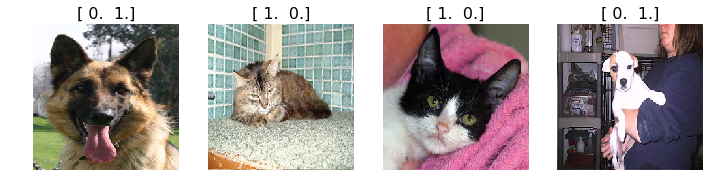

In [67]:
imgs, labels = next(batches)
plots(imgs, titles=labels)

In [65]:
# The VGG model return 1,000 imagenet category probabilities for each image
def pred_batch(imgs):
    preds = model.predict(imgs)
    idxs = np.argmax(preds, axis=1)
    
    print('Shape: {}'.format(preds.shape))
    print('First 5 classes:{}'.format(classes[:5]))
    print('First 5 probabilities: {}\n'.format(preds[0, :5]))
    print('Predictions prob/class: ')
    
    for i in range(len(idxs)):
        idx = idxs[i]
        print(' {:.4f}/{}'.format(preds[i, idx], classes[idx]))

In [68]:
pred_batch(imgs)

Shape: (4, 1000)
First 5 classes:[u'tench', u'goldfish', u'great_white_shark', u'tiger_shark', u'hammerhead']
First 5 probabilities: [  4.5325e-09   1.0652e-09   2.0241e-09   1.8105e-09   1.3134e-09]

Predictions prob/class: 
 0.8945/German_shepherd
 0.2259/Persian_cat
 0.5647/feather_boa
 0.1617/hand_blower
